# *E. coli* Live Simulation Notebook

## Setup Simulation

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import datetime

WC_ECOLI_DIRECTORY = os.path.expanduser("~/wcEcoli")
OUT_DIRECTORY = os.path.join(WC_ECOLI_DIRECTORY, "out")

now = datetime.datetime.now()
SUBMISSION_TIME = "%04d%02d%02d.%02d%02d%02d.%06d" % (
	now.year, now.month, now.day,
	now.hour, now.minute, now.second,
	now.microsecond)

JUPYTER_OUT_DIR = "jupyter"
KB_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "kb")
METADATA_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "metadata")
CELL_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "wildtype_000000", "000000", "generation_000000", "000000")
SIM_DATA_PATH = os.path.join(KB_DIRECTORY, "simData_Fit_1.cPickle")
SIM_OUT_PATH = os.path.join(CELL_DIRECTORY, "simOut")
PLOT_OUT_PATH = os.path.join(CELL_DIRECTORY, "plotOut")

if not os.path.exists(KB_DIRECTORY):
    os.makedirs(KB_DIRECTORY)

if not os.path.exists(METADATA_DIRECTORY):
    os.makedirs(METADATA_DIRECTORY)
    
if not os.path.exists(CELL_DIRECTORY):
    os.makedirs(CELL_DIRECTORY)
    
if not os.path.exists(SIM_OUT_PATH):
    os.makedirs(SIM_OUT_PATH)
    
if not os.path.exists(PLOT_OUT_PATH):
    os.makedirs(PLOT_OUT_PATH)

sys.path.append(WC_ECOLI_DIRECTORY)

Load and fit the data.

In [2]:
import cPickle
from reconstruction.ecoli.knowledge_base_raw import KnowledgeBaseEcoli
from reconstruction.ecoli.fit_sim_data_1 import fitSimData_1
from reconstruction.ecoli.fit_sim_data_2 import fitSimData_2

raw_data = KnowledgeBaseEcoli()
sim_data = fitSimData_1(raw_data)

with open(SIM_DATA_PATH, 'wb') as f:
    cPickle.dump(sim_data, f, cPickle.HIGHEST_PROTOCOL)

In [19]:
from models.ecoli.sim.simulation import EcoliSimulation

class EcoliLiveSimulation(EcoliSimulation):
    def startup(self):
        # Perform initial mass calculations
        for state in self.states.itervalues():
            state.calculatePreEvolveStateMass()
            state.calculatePostEvolveStateMass()

        # Perform initial listener update
        for listener in self.listeners.itervalues():
            listener.initialUpdate()

        # Start logging
        for logger in self.loggers.itervalues():
            logger.initialize(self)
            
    def step(self, steps=1, time=None, sync_every=None):
        startTime = self._timeTotal
        stepCount = 0
        
        while True:
            stepCount += 1
            
            if steps > 0 and stepCount > steps:
                break
            
            if time is not None and startTime + time < self._timeTotal:
                break
            
            if self._cellCycleComplete:
                print "Cell cycle complete"
                break
                
            if sync_every is not None and stepCount % sync_every == 0:
                self._syncwrites()

            self._simulationStep += 1
            self._timeTotal += self._timeStepSec
            self._evolveState()
        
        self._syncwrites()
            
    def _syncwrites(self):
        # If python didn't want OO-breaking manipulation of private data,
        # it would have had visibility specification.

        for obj, saveFile in dict(self.loggers['Disk'].saveFiles, mainFile=self.loggers['Disk'].mainFile).iteritems():
            if saveFile._columns is not None:
                for name, column in saveFile._columns.iteritems():
                    column._data.flush()
                    column._offsets.flush()
                    os.fsync(column._data)
                    os.fsync(column._offsets)
    
    def shutdown(self):
        # Run post-simulation hooks
        for hook in self.hooks.itervalues():
            hook.finalize(self)

        # Divide mother into daughter cells
        self._divideCellFunction()

        # Finish logging
        for logger in self.loggers.itervalues():
            logger.finalize(self)

In [31]:
sim.listeners['EnzymeKinetics'].metaboliteIDs

[u'2-3-DIHYDROXYBENZOATE[c]',
 u'2-KETOGLUTARATE[c]',
 u'4-hydroxybenzoate[c]',
 u'ACETOACETYL-COA[c]',
 u'ACETYL-COA[c]',
 u'ACETYL-P[c]',
 u'ADENINE[c]',
 u'ADENOSINE[c]',
 u'ADP-D-GLUCOSE[c]',
 u'ADP[c]',
 u'AMP[c]',
 u'ANTHRANILATE[c]',
 u'APS[c]',
 u'ARG[c]',
 u'ASN[c]',
 u'ATP[c]',
 u'BIOTIN[c]',
 u'CA+2[c]',
 u'CARBAMYUL-L-ASPARTATE[c]',
 u'CHORISMATE[c]',
 u'CIS-ACONITATE[c]',
 u'CIT[c]',
 u'CL-[c]',
 u'CMP[c]',
 u'CO+2[c]',
 u'CO-A[c]',
 u'CPD-12115[c]',
 u'CPD-12261[p]',
 u'CPD-12575[c]',
 u'CPD-12819[c]',
 u'CPD-12824[c]',
 u'CPD-13469[c]',
 u'CPD-2961[c]',
 u'CPD-8260[c]',
 u'CPD-9956[c]',
 u'CPD0-939[c]',
 u'CTP[c]',
 'CYS[c]',
 u'CYTIDINE[c]',
 u'CYTOSINE[c]',
 u'DAMP[c]',
 u'DATP[c]',
 u'DCTP[c]',
 u'DEOXYADENOSINE[c]',
 u'DEOXYGUANOSINE[c]',
 u'DGMP[c]',
 'DGTP[c]',
 u'DI-H-OROTATE[c]',
 u'DIHYDROXY-ACETONE-PHOSPHATE[c]',
 u'ENTEROBACTIN[c]',
 u'FAD[c]',
 u'FE+2[c]',
 u'FRUCTOSE-16-DIPHOSPHATE[c]',
 u'FUM[c]',
 u'G3P[c]',
 u'GDP[c]',
 u'GLC-D-LACTONE[c]',
 u'GLN[c]',
 u

In [20]:
options = {}

options["simDataLocation"] = SIM_DATA_PATH
options["outputDir"] = os.path.join(CELL_DIRECTORY, "simOut")
options["logToDisk"] = True
options["overwriteExistingFiles"] = False

sim = EcoliLiveSimulation(**options)

In [5]:
from wholecell.io.tablereader import TableReader

In [33]:
#%%timeit
tr = TableReader(os.path.join(SIM_OUT_PATH, "FBAResults"))
a = tr.readColumn('outputFluxes')

In [11]:
for name, listener in sim.listeners.iteritems():
    print "%s:" % name
    for attribute in listener.__dict__.keys():
        if not attribute.startswith("_"):
            print "  %s" % attribute

Mass:
  dnaIndex
  rRnaIndexes
  expectedDryMassIncrease
  massUnits
  rnaIndexes
  tRnaIndex
  setInitial
  smallMoleculeIndexes
  states
  processNames
  proteinIndex
  mRnaIndex
  dryMass
  waterIndex
  cellCycleLen
ReplicationData:
  sequenceLength
  refractionOver
  sequenceIdx
  criticalMassPerOriC
  uniqueMolecules
  diffFactorActive
  lastPassedCriticalMass
  numberOfOric
RibosomeData:
  stallingRateStd
  expectedElongations
  ribosomeStalls
  effectiveElongationRate
  stallingRateTotal
  terminationLoss
  aaCounts
  didInitialize
  aaCountInSequence
  stallingRateMean
  didTerminate
  fractionStalled
  actualElongations
UniqueMoleculeCounts:
  uniqueMoleculeCounts
  uniqueMolecules
FBAResults:
  externalExchangeFluxes
  externalMoleculeIDs
  outputFluxes
  reactionIDs
  objectiveComponents
  reactionFluxes
  outputMoleculeIDs
  metabolism
  objectiveValue
RnaDegradationListener:
  countRnaDegraded
  nucleotidesFromDegradation
  FractEndoRRnaCounts
  countUnits
  DiffRelativeFi

In [7]:
sim.listeners['Mass'].dryMass

0.0

In [119]:
import wholecell.loggers.logger
import matplotlib.pyplot as plt

class IPythonLogger(wholecell.loggers.logger.Logger):
    _fig, _ax, _im = None, None, None
    
    _time = []
    _data = []
    
    def __init__(self, figure, axes):
        self._fig, self._ax = figure, axes
    
    def initialize(self, sim):
        pass
    
    def finalize(self, sim):
        pass
    
    def append(self, sim):
        fig, ax = self._fig, self._ax
        
        self._time.append(sim.time())
        self._data.append(sim.listeners['FBAResults'].externalExchangeFluxes.reshape(8,9))
        
        if self._im:
            self._im.set_data(self._data[-1])
#             for i in range(self._data[0].shape[0]):
#                 ax.lines[i].set_xdata(self._time)
#                 ax.lines[i].set_ydata([x[i] for x in self._data])
        else:
#             ax.plot(self._time, self._data, label=sim.listeners['FBAResults'].externalMoleculeIDs)
#             a1.pcolor(self._data[0].reshape(8,9), cmap=plt.cm.Blues, vmin=max(-1., data.min()), vmax=data.max())
            self._im = ax.imshow(self._data[0], interpolation='nearest', aspect='auto', cmap='RdBu')
            fig.colorbar(self._im)


            
#         ax.relim()
#         ax.autoscale_view(True,True,True)
        fig.canvas.draw()

In [128]:
sim.processes['Metabolism'].r

{u'1.1.1.39-RXN': {'constraintActive': 0,
  'constraintID': u'1.1.1.39-RXN',
  'customParameterConstantValues': None,
  'customParameterConstants': None,
  'customParameterVariables': None,
  'customParameters': None,
  'customRateEquation': None,
  'enzymeIDs': [u'MALIC-NAD-CPLX[c]'],
  'kI': [],
  'kM': [660, 68.8],
  'kcat': [82.7],
  'rateEquationType': u'standard',
  'reactionID': u'1.1.1.39-RXN',
  'substrateIDs': [u'MAL[c]', u'NAD[c]']},
 u'1.1.1.39-RXN_kcat_82.7': {'constraintActive': 0,
  'constraintID': u'1.1.1.39-RXN_kcat_82.7',
  'customParameterConstantValues': None,
  'customParameterConstants': None,
  'customParameterVariables': None,
  'customParameters': None,
  'customRateEquation': None,
  'enzymeIDs': [u'MALIC-NAD-CPLX[c]'],
  'kI': [],
  'kM': [],
  'kcat': [82.7],
  'rateEquationType': u'standard',
  'reactionID': u'1.1.1.39-RXN',
  'substrateIDs': []},
 u'2.5.1.19-RXN': {'constraintActive': 0,
  'constraintID': u'2.5.1.19-RXN',
  'customParameterConstantValues':

In [122]:
sim.listeners['FBAResults'].reactionIDs[:50]

array([u'1.1.1.83-RXN', u'RXN-14483-CPD-16502/WATER//CPD-16501/Pi.30.',
       u'TRANS-RXN0-567 (reverse)',
       u'3.2.1.17-RXN-C6/WATER//C5/N-ACETYL-D-GLUCOSAMINE.36.',
       u'TAGAALDOL-RXN (reverse)', u'RXN0-7074', u'RXN0-7075',
       u'DGDPKIN-RXN', u'TRANS-RXN0-590',
       u'OHACYL-COA-DEHYDROG-RXN-NAD/OH-HEXANOYL-COA//NADH/K-HEXANOYL-COA/PROTON.48.',
       u'TRANS-RXN0-592', u'TRANS-RXN0-593', u'TRANS-RXN0-266',
       u'TRANS-RXN0-264', u'GUANYLCYC-RXN',
       u'TRANS-RXN-20-CPD0-1107/PROTON//CPD0-1107/PROTON.35.',
       u'TRANS-RXN0-268', u'TRANS-RXN0-269',
       u'RXN0-5190[CCI-PERI-BAC-GN]-Peptidoglycan-dimer//NAcMur-Peptide-NAcGlc-Undecaprenols/GlcNAc-1-6-anhydro-MurNAc-pentapeptide.113. (reverse)',
       u'ADENYLYLSULFKIN-RXN (reverse)',
       u'GLYOHMETRANS-RXN-SER/THF//GLY/METHYLENE-THF/WATER.33. (reverse)',
       u'TRANS-RXN0-267-L-ALA-GAMMA-D-GLU-DAP/PROTON//L-ALA-GAMMA-D-GLU-DAP/PROTON.59.',
       u'ABC-42-RXN-CPD-15629/ATP/WATER//CPD-15629/ADP/Pi/PROTON.4

<IPython.core.display.Javascript object>


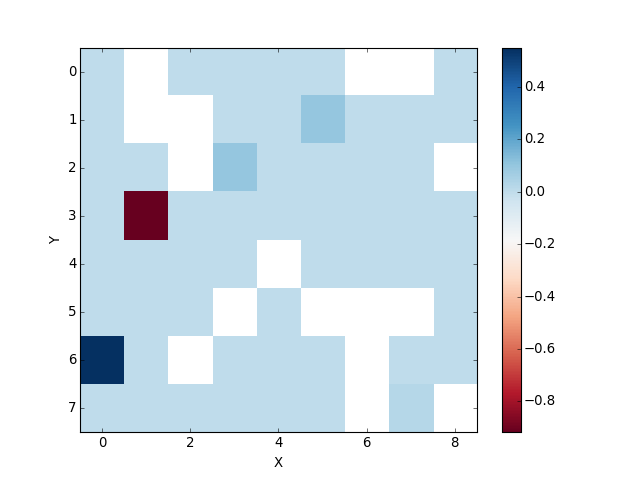

In [120]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

iplogger = IPythonLogger(fig, ax)
sim.loggers['IPython'] = iplogger

In [118]:
fig.colorbar(sim.loggers['IPython']._im)
fig.canvas.draw()

In [121]:
sim.step(steps=100)

     259    262.23        1.068        1.053        1.044        1.051
     260    262.27        1.068        1.053        1.044        1.051
     261    262.32        1.069        1.054        1.044        1.052
     262    262.37        1.069        1.054        1.045        1.052
     262    262.42        1.069        1.054        1.045        1.052
     263    262.47        1.069        1.054        1.045        1.052
     264    262.52        1.070        1.054        1.045        1.052
     265    262.57        1.070        1.054        1.045        1.052
     266    262.62        1.070        1.055        1.045        1.053
     267    262.66        1.070        1.055        1.046        1.053
     268    262.71        1.070        1.055        1.046        1.053
     269    262.75        1.070        1.055        1.046        1.053
     270    262.80        1.071        1.055        1.046        1.053
     270    262.84        1.071        1.056        1.046        1.054
     2

<IPython.core.display.Javascript object>


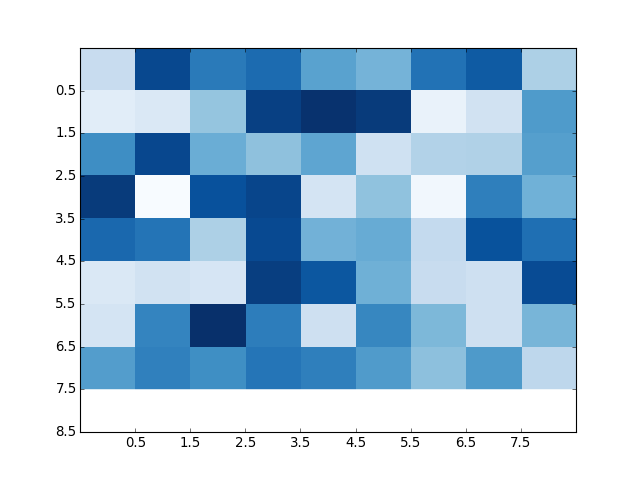

-inf 0.499181726554
[[ 0.24854428  0.90526281  0.71384335  0.77295118  0.55465185  0.4804881
   0.74535763  0.83523442  0.33222989]
 [ 0.11523861  0.15438877  0.40350989  0.93471113  0.98778384  0.95507313
   0.07650642  0.19760268  0.58900094]
 [ 0.64224498  0.90863229  0.50609299  0.41905357  0.54073463  0.21127733
   0.31686098  0.32562023  0.56689379]
 [ 0.95240461  0.01082543  0.87076186  0.91480966  0.18412442  0.41504803
   0.03887495  0.69452446  0.4898543 ]
 [ 0.78526038  0.73709487  0.33209212  0.90065439  0.48692872  0.5129769
   0.26209224  0.86766216  0.75879685]
 [ 0.15189711  0.20069889  0.17583991  0.9427324   0.84792129  0.49472145
   0.24393412  0.21886756  0.89036098]
 [ 0.18415109  0.67757399  0.99793949  0.70352261  0.21318627  0.66723034
   0.45967482  0.21316179  0.4717382 ]
 [ 0.57700468  0.69328918  0.63703708  0.73454748  0.69643507  0.58510043
   0.42306309  0.59142117  0.28113133]]


In [76]:
import numpy as np

fig, a1 = plt.subplots()
data = sim.listeners['FBAResults'].externalExchangeFluxes.reshape(8,9)
data2 = np.random.random((8,9))

print data.min(), data.max()
print data2
im = a1.imshow(data2, interpolation='nearest', aspect='auto', cmap='Blues')
# a1.pcolor(data2, vmin=0, vmax=1)
a1.set_xticks(np.arange(8)+0.5, minor=False)
a1.set_yticks(np.arange(9)+0.5, minor=False)
plt.show()

<IPython.core.display.Javascript object>


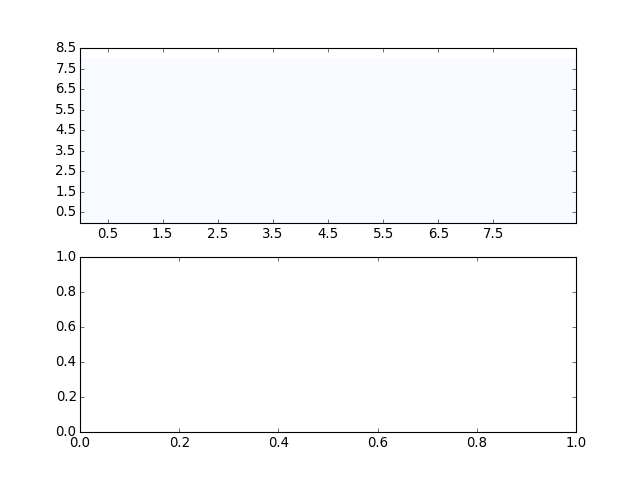

In [42]:
fig, (a1, a2) = plt.subplots(2,1)

In [ ]:
fig.legend()

In [27]:
sim.startup()

Time (s)  Dry mass     Dry mass      Protein          RNA     Expected
              (fg)  fold change  fold change  fold change  fold change
========  ========  ===========  ===========  ===========  ===========
     671    284.47        1.159        1.141        1.127        1.138


In [28]:
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sim.step(steps=100)

     672    284.51        1.159        1.141        1.127        1.138
     672    284.56        1.159        1.141        1.127        1.138
     673    284.61        1.160        1.142        1.127        1.139
     674    284.66        1.160        1.142        1.128        1.139
     675    284.72        1.160        1.142        1.128        1.139
     676    284.77        1.160        1.142        1.128        1.139
     677    284.82        1.160        1.142        1.128        1.139
     678    284.87        1.161        1.143        1.128        1.140
     679    284.92        1.161        1.143        1.129        1.140
     680    284.97        1.161        1.143        1.129        1.140
     681    285.02        1.161        1.143        1.129        1.140
     681    285.07        1.161        1.143        1.129        1.140
     682    285.11        1.162        1.144        1.129        1.141
     683    285.17        1.162        1.144        1.130        1.141
     6

<IPython.core.display.Javascript object>


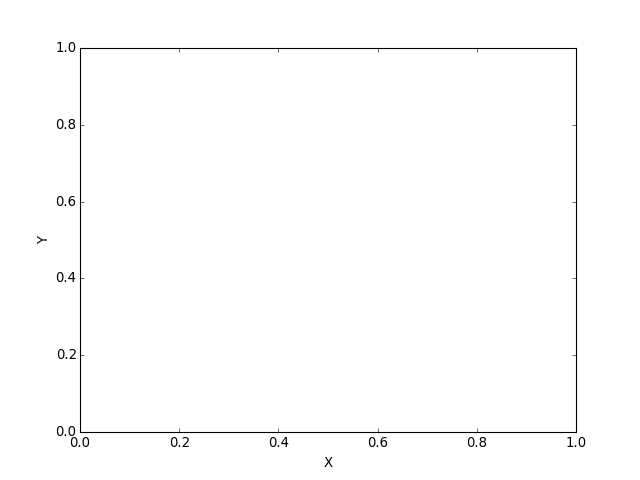

KeyError: 'IPython'

In [8]:
%matplotlib notebook

fig, ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

time = sim.loggers['IPython']._time
data = sim.loggers['IPython']._data
labels = sim.listeners['FBAResults'].externalMoleculeIDs

ax.plot(time, data)

fig.show()

In [210]:
sim.listeners['Mass'].dryMass

268.50010625108314

In [109]:
sim.shutdown()


Simulation finished:
 - Length: 0:00:21
 - Runtime: 0:00:37



In [12]:
import importlib
from IPython.display import SVG

def analyse(plot):
    mod = importlib.import_module("models.ecoli.analysis.single." + plot)
    mod.main(SIM_OUT_PATH, PLOT_OUT_PATH, plot, SIM_DATA_PATH, None, None)
    return SVG(filename=os.path.join(PLOT_OUT_PATH, "svg_plots", "%s.svg" % plot))

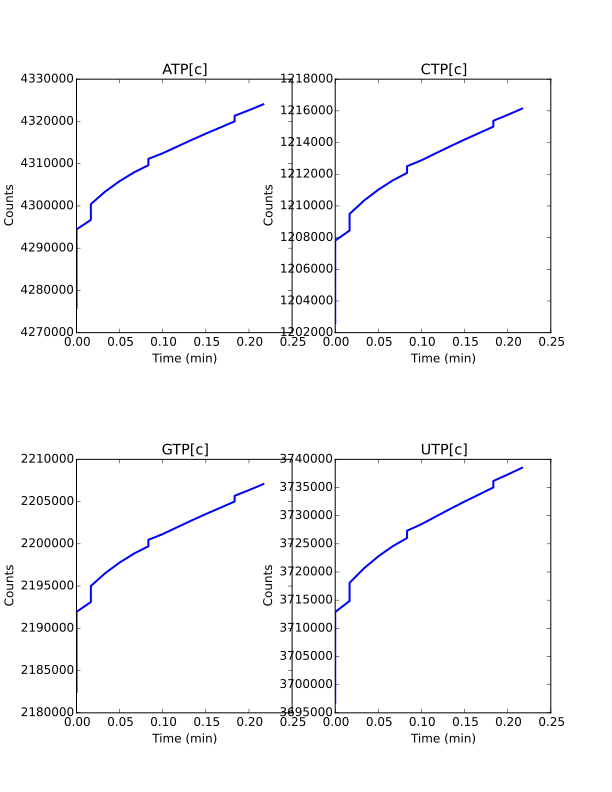

In [15]:
analyse("ntpCounts")

<IPython.core.display.Javascript object>


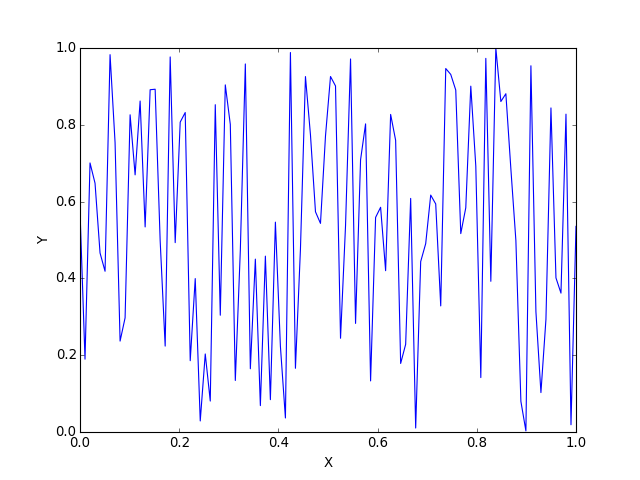

/share/PI/mcovert/pyenv/versions/wcEcoli/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)
/share/PI/mcovert/pyenv/versions/wcEcoli/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)
/share/PI/mcovert/pyenv/versions/wcEcoli/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)
/share/PI/mcovert/pyenv/versions/wcEcoli/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: DeprecationWarning: using a non-integer number instead of an int

KeyboardInterrupt: 

In [214]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = (8, 6)

def pltsin(ax):
    x = np.linspace(0,1,100)
    y = np.random.random(size=(100,1))
    if len(ax.lines):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
    else:
        ax.plot(x,y)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(60):
    pltsin(ax)
    time.sleep(1)